# Understanding SVD

Diagonalisation of square matrix ??

Summary:
- 1. Definition of Singuar Values Decomposition
- 2. SVD applied to image compression
- 3. SVD applied to function approximation
- 4. Linear Regression
- 5. PCA

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import LinearRegression

# Reproducability
np.random.seed(15)

## 1. Definition of Singuar Values Decomposition

**Singular Value Decomposition Theorem:** Let $A$ be a real (or complex) $m \times n$ matrix. The Singular Value Decomposition (SVD) of $A$ is a factorization of the form:
$$
\mathbf{A} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \qquad \text{with} \qquad {\mathbf{\Sigma}} = \begin{bmatrix}
    \sigma_1 & 0 & \cdots & 0   \\
    0 & \sigma_2 & \ddots & \vdots \\
    \vdots & \ddots & \ddots & 0 \\
    \vdots & & \ddots &  \sigma_m\\
    \vdots &  &  &  0 \\
    0 & \cdots & \cdots & 0
\end{bmatrix} \in \mathbb{R}^{m \times n}
$$

$$
\Sigma = 
\begin{bmatrix}
    \sigma_1 & 0 & \cdots & 0 \\
    0 & \sigma_2 & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & \sigma_r \\
    \hline
    0 & \cdots & \cdots & 0
\end{bmatrix}
\in \mathbb{R}^{m \times n}
$$

where:
- $U \in \mathbb{R}^{m \times m}$ is an orthogonal matrix, i.e., $U^T U = I_m$. Its columns are the left singular vectors of $A$.
- $V \in \mathbb{R}^{n \times n}$ is an orthogonal matrix, i.e., $V^T V = I_n$. Its columns are the right singular vectors of $A$.
- $\Sigma \in \mathbb{R}^{m \times n}$ is a diagonal matrix with the *singular values* of $\sigma_i$ on the diagonal.

The matrix $\Sigma$ has been represented in the case $n > m$. The $\sigma_i$ are called the singular values of $\mathbf{A}$. They are the square roots of the eigenvalues of the matrix ${\mathbf{A}}^H{\mathbf{A}}$. They are necessarily *real, positive, or zero*; they can be arranged in any order, but for a given order, the decomposition is unique. From now on, we choose descending order: $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$ (where $r = \operatorname{rank}(A)$)

The result can also be written as:  
$${\mathbf{A}} = {\mathbf{U}}{\mathbf{\Sigma}}{\mathbf{V}}^T = \sum_{i=1}^r \sigma_i {\mathbf{u}}_i {\mathbf{v}}_i^T$$  
which expresses the matrix as the sum of $\operatorname{rank}({\mathbf{A}})$ matrices of rank-1 contributions.



### Geometric Interpretation

The SVD provides a geometric interpretation of the action of the matrix $A$: it maps the unit sphere in $\mathbb{R}^n$ to an ellipsoid in $\mathbb{R}^m$, where the axes of the ellipsoid are scaled by the singular values and oriented along the left singular vectors.

### Applications of SVD

SVD is a fundamental tool in linear algebra with applications in:

- Principal Component Analysis (PCA)
- Signal processing and data compression
- Solving ill-posed linear systems
- Latent Semantic Analysis (LSA) in natural language processing



### Algorithm

We will now code the SVD in the case of a real square matrix. We therefore write ${\mathbf{A}} = {\mathbf{U}}{\mathbf{\Sigma}}{\mathbf{V}}^T$. The computation of the SVD consists in finding the eigenvalues and eigenvectors of $\mathbf{A}\mathbf{A}^T$ and $\mathbf{A}^T\mathbf{A}$. The eigenvectors of $\mathbf{A}^T\mathbf{A}$ form the columns of $\mathbf{V}$, while the eigenvectors of $\mathbf{A}\mathbf{A}^T$ form the columns of $\mathbf{U}$. As stated earlier, the singular values in $\mathbf{\Sigma}$ are the square roots of the eigenvalues of either $\mathbf{A}\mathbf{A}^T$ or $\mathbf{A}^T\mathbf{A}$.

The singular values are the diagonal entries of the matrix $\mathbf{\Sigma}$ and are sorted in decreasing order, and the eigenvectors in U and V matrices are reordered accordingly. Since in this case $\mathbf{A}$ is a real matrix, both $\mathbf{U}$ and $\mathbf{V}$ are also real. Finally, we must not forget that we must have:  
$${\mathbf{A}}\mathbf{V} = \mathbf{U}\mathbf{\Sigma}$$


In [6]:
n = 6
A = np.random.random((n, n))

def svd(A):
    S, U = la.eigh(A.dot(A.T))
    S, V = la.eigh(A.T.dot(A))
    S = np.sqrt(S)
    idx = S.argsort()[::-1]
    S = S[idx]
    U = U[:,idx]
    V = V[:,idx]
    # matrice de 1 et -1 pour obtenir AV = US avec test d'égalité (true=1, false=0)
    # on fait 2 * test d'égalité - 1 -> donne true=1, false=-1
    MS = 2 * np.isclose(A.dot(V), (U.dot(np.diag(S)))) - 1
    print(MS)
    V = MS * V
    return U, S, V


# custom function call
U, S, V = svd(A)
S = np.diag(S) # vector to matrix

# SVD using numpy's built-in function
Unp, Snp, Vnp = la.svd(A)
Snp = np.diag(Snp)

print(np.allclose(A, U.dot(S.dot(V.T))))
print(np.allclose(A, Unp.dot(Snp.dot(Vnp))))

[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]
True
True


## 2. SVD applied to image compression

$$
\min_{{\operatorname{rg}({\mathbf{B}})}=k}\|{\mathbf{A}}-{\mathbf{B}}\|_2 = \|{\mathbf{A}}-{\mathbf{A}}_k\|_2 = \sigma_{k+1}\quad\text{ où } {\mathbf{A}}_k=\sum_{i=1}^k\sigma_i{\mathbf{u}}_i {\mathbf{v}}_i^T
$$


On voit aussi que ${\mathbf{A}}_k$ est le meilleur représentant de ${\mathbf{A}}$ de rang $k$ (au sens de la norme euclidienne) et représente la borne inférieure de l'erreur commise.

In [ ]:
n = 20
index = np.arange(1, n+1)
A = np.random.random((n, n))
U, S, V = la.svd(A)

plt.figure(figsize=(10,3))
plt.title("Singular values")
plt.bar(index, S)
plt.xticks(index)
plt.show()

# recontruction de rang k et calcul de la norme 2 associee par rapport a la matrice complete
norms = []
comps = list(range(n))
for i in range(n):
    Ak = U[:, :comps[i]] @ np.diag(S[:comps[i]]) @ V[:comps[i], :]
    norms += [la.norm((A-Ak),2)]

plt.figure(figsize=(10,3))
plt.title("$\|{\mathbf{A}}-{\mathbf{A}_k}\|_2$")
plt.bar(index, norms)
plt.xticks(index)
plt.show()



: 

In [ ]:


from skimage import color
from skimage import io

# Chargement de l'image et conversion en niveaux de gris
jardin = io.imread('jardin.jpg', as_gray=True)
jardarray = np.asarray(jardin)
# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(jardin, cmap='gray'),
plt.title('Image originale')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()

# SVD
U,S,V = la.svd(jardarray)

# Composantes à tracer
comps = [1000, 1, 5, 10, 15, 20, 50, 100, 200 ]
plt.figure(figsize=(12, 6))

for i in range(len(comps)):
    jardin_rank = U[:, :comps[i]] @ np.diag(S[:comps[i]]) @ V[:comps[i], :]

    if(i == 0):
        plt.subplot(3, 3, i+1),
        plt.imshow(jardin, cmap='gray'),
        plt.title(f'Image avec {comps[i]} composantes')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])
    else:
        plt.subplot(3, 3, i+1),
        plt.imshow(jardin_rank, cmap='gray'),
        plt.title(f'{comps[i]} comp.')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])
plt.show()
# L'originale et la version a 400 composantes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1),
plt.imshow(jardin, cmap='gray'),
plt.title('Image originale')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.subplot(1, 2, 2),
jardin_rank = U[:, :400] @ np.diag(S[:400]) @ V[:400, :]
plt.imshow(jardin_rank, cmap='gray'),
plt.title('Image 400 composantes')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()
# liste des valeurs singulières
mylist=list(range(1,501))
mybar = S[:500]
plt.figure(figsize=(10,3))
plt.title("Valeurs singulières")
plt.bar(mylist, mybar)
plt.show()
# Norme 2 entre image d'origine et celle de rang i
mybar=[]
comps = list(range(100))
for i in range(len(comps)):
    jardin_rank = U[:, :comps[i]] @ np.diag(S[:comps[i]]) @ V[:comps[i], :]
    mybar = mybar + [la.norm((jardarray-jardin_rank),2)]

plt.figure(figsize=(10,3))
plt.title("$\||{\mathbf{jardin}}-{\mathbf{jardin_k}}\||_2$")
plt.bar(comps, mybar)
plt.show()


## 3. SVD applied to function approximation

## 4. Linear Regression

Linear regression aims to find the parameter vector $ \Theta \in \mathbb{R}^d $ that best fits a set of observations $ (X, y) $, where $X \in \mathbb{R}^{n \times d} $ is the design matrix and $ y \in \mathbb{R}^n $ is the vector of target values. The model assumes a linear relationship given by the matrix equation:
$$
X \Theta = y.
$$
When $ X $ does not have full column rank or when the system is overdetermined (i.e., $ n > d $), the equation may not have an exact solution. In such cases, we seek the least-squares solution that minimizes the squared error $ \| X \Theta - y \|_2^2 $. This analytical solution is given by:
$$
\Theta = X^{+} y,
$$
where $ X^{+} $ denotes the Moore–Penrose pseudoinverse of $ X $. To compute $ X^{+} $, we can use the singular value decomposition (SVD). Let $ X = U \Sigma V^\top $ be the SVD of $ X $, then the pseudoinverse is given by:
$$
X^{+} = V \Sigma^{+} U^\top,
$$
where $ \Sigma^{+} $ is formed by taking the reciprocal of each non-zero singular value in $ \Sigma $, transposing the resulting matrix, and padding with zeros if necessary. This approach ensures a stable and general solution, even when $ X $ is not of full rank.


## Example: Linear Regression with Two Parameters

In simple linear regression with two parameters, we aim to model the relationship between a scalar input $x$ and a target variable $y$ as a linear function:
$$
y = \theta_0 + \theta_1 x,
$$
where $\theta_0$ is the intercept and $\theta_1$ is the slope. Given a dataset of $n$ observations $(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)$, we can write the model in matrix form as:
$$
X \Theta = y,
$$
with:
$$
X = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n \\
\end{bmatrix}, \quad
\Theta = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\end{bmatrix}, \quad
y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}.
$$

To find the best linear fit in the least-squares sense, we seek the parameter vector $\hat{\Theta}$ given by:
$$
\hat{\Theta} = X^+ y \qquad with \qquad X^+ = V \Sigma^+ U^\top


$$
This leads to a stable and general method for solving the linear regression problem, even when $X$ is not of full rank. For this simple 2-parameter regression, the formulas can be computed analytically:

$$
\theta_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}   
$$
$$
\theta_0 = \bar{y} - \theta_1 \bar{x}
$$

where $\bar{x}$ and $\bar{y}$ represent the mean of those lists.

True
True
True


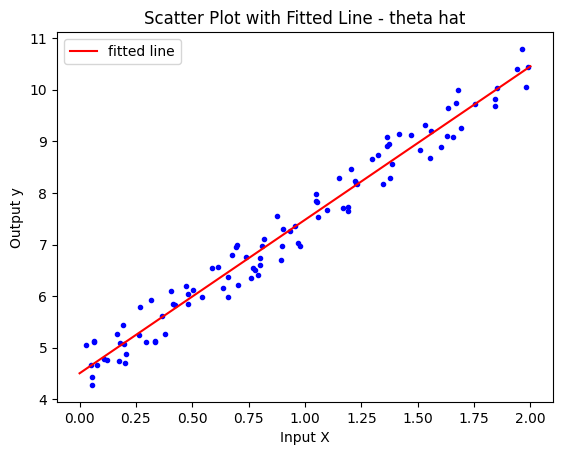

In [ ]:
# Inputs X
nb_points = 100
X = 2 * np.random.rand(nb_points, 1)
X_b = add_dummy_feature(X) # add a column (all 1s)

# Outputs y
bias = 4
slope = 3
y = bias + slope * X + np.random.rand(nb_points, 1) # add noise




# SVD
U, S, V = la.svd(X_b)
St = np.diag([1/s if s > 1e-6 else 0 for s in S])
St = np.hstack([St, np.zeros((2, 98))])
theta_svd = V.T @ St @ U.T @ y

# PSEUDO INVERSE
theta_la = np.linalg.pinv(X_b) @ y

# LINEAR REGRESSION
model = LinearRegression()
model.fit(X, y.ravel())
theta_lr = np.array([[model.intercept_], model.coef_])

# FORMULAS
x_mean = np.mean(X)
y_mean = np.mean(y)
theta_1 = np.sum((X - x_mean) * (y - y_mean)) / np.sum((X - x_mean) ** 2)
theta_0 = y_mean - theta_1 * x_mean
theta_formula = [[theta_0], [theta_1]]



# VERIFICATION
print(np.allclose(theta_svd, theta_la))
print(np.allclose(theta_svd, theta_lr))
print(np.allclose(theta_svd, theta_formula))





# form a line from 2 points
x_line = np.array([[0], [2]])
y_line = add_dummy_feature(x_line) @ theta_svd # 1 * theta0 + x * theta1



# Plot graph
plt.plot(X, y, "b.") 
plt.plot(x_line, y_line, "red", label="fitted line")
plt.xlabel("Input X")
plt.ylabel("Output y")
plt.title("Scatter Plot with Fitted Line - theta hat")
plt.legend()
plt.show()

## 5. PCA